# **CATASCAN**

### Instalasi dan Import Library

In [1]:
!pip install tensorflow
!pip install numpy matplotlib
!pip install scikit-learn
!pip install ultralytics
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu116


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Looking in indexes: https://download.pytorch.org/whl/cu116


ERROR: Could not find a version that satisfies the requirement torchaudio (from versions: none)

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip
ERROR: No matching distribution found for torchaudio


In [2]:
# Import library
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from ultralytics import YOLO
import os
import cv2
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.regularizers import l2

### Verifikasi GPU dan CUDA

In [3]:
import torch

print(f"Is CUDA available? {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
else:
    print("No GPU detected.")


Is CUDA available? False
No GPU detected.


### Model YOLO Pre-trained

In [4]:
yolo_model = YOLO('yolov8n.pt')
print("YOLO model loaded successfully!")

YOLO model loaded successfully!


### Fungsi dan Dataset untuk YOLO

In [5]:
yolo_data_dir = "C:/Users/Ria/Documents/capstone/dataset/dataset_yolo.v4i.yolov8/"

# Fungsi untuk deteksi mata dan memberikan peringatan
def detect_and_warn(image_path, distance_threshold=50):
    """
    Mendeteksi mata dalam gambar dan memberikan peringatan jika objek terlalu jauh.
    """
    print(f"Checking image at path: {image_path}")

    # Prediksi dengan YOLO
    results = yolo_model.predict(source=image_path, conf=0.3) 

    print(f"Raw YOLO results: {results}")

    for result in results:
       
        print(f"Number of boxes detected: {len(result.boxes)}")
        if len(result.boxes) > 0:
            for box in result.boxes:
                cls = int(box.cls[0])
                label = result.names[cls]
              
                print(f"Detected: {label} with confidence {box.conf[0]} at coordinates {box.xyxy[0]}")
                if label == "eye":
                    x1, y1, x2, y2 = map(int, box.xyxy[0])
                    distance = x2 - x1
                    print(f"Eye detected with distance: {distance}")
                    if distance < distance_threshold:
                        print(f"Warning: Eye too far at {image_path} (distance: {distance})")
                else:
                    print(f"Detected object is not an eye: {label} at {image_path}")
        else:
            print(f"No objects detected in {image_path}")


In [6]:
yolo_data_dir = "C:/Users/Ria/Documents/capstone/dataset/dataset_yolo.v4i.yolov8"

yolo_model = YOLO("yolov8n.pt") 

In [7]:
# Memuat model YOLO dengan weights (checkpoint terakhir)
yolo_model = YOLO('C:/Users/Ria/Documents/capstone/runs/detect/train3/weights/last.pt')

### Training YOLO Model

In [ ]:
print("Starting YOLO model training...")
yolo_model.train(
    data=os.path.join(yolo_data_dir, "data.yaml"),  
    epochs=50,  
    imgsz=640, 
    batch=16,  
    device="cpu",
    resume=True
)
print("YOLO model training complete!")

In [8]:
new_test_image = "C:/Users/Ria/Documents/capstone/ayodeteksi11.jpg"

print(f"Testing detection on: {new_test_image}")
results = yolo_model.predict(source=new_test_image, conf=0.3)

results[0].show()

Testing detection on: C:/Users/Ria/Documents/capstone/ayodeteksi11.jpg

image 1/1 C:\Users\Ria\Documents\capstone\ayodeteksi11.jpg: 640x384 2 eyes, 164.8ms
Speed: 10.3ms preprocess, 164.8ms inference, 22.7ms postprocess per image at shape (1, 3, 640, 384)


### Persiapan Data Awal: Augmentasi dan Preprocessing

In [9]:
train_dir = "dataset\\eye_cataracwithlabels - Copy - Copy\\train"
valid_dir = "dataset\\eye_cataracwithlabels - Copy - Copy\\valid"
test_dir = "dataset\\eye_cataracwithlabels - Copy - Copy\\test"

class_labels = ['Immature', 'Mature', 'Normal']

#Verifikasi jumlah data di setiap folder
num_train = sum([len(files) for r, d, files in os.walk(train_dir)])
num_valid = sum([len(files) for r, d, files in os.walk(valid_dir)])
num_test = sum([len(files) for r, d, files in os.walk(test_dir)])

print(f"Number of training images: {num_train}")
print(f"Number of validation images: {num_valid}")
print(f"Number of test images: {num_test}")

if num_train == 0 or num_valid == 0:
    raise ValueError("Training or validation dataset is empty! Please check your dataset.")

# Data Augmentation untuk training
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.3, brightness_range=(0.8, 1.2),
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1.0/255)

test_datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224), 
    batch_size=32,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    valid_dir,
    target_size=(224, 224), 
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224), 
    batch_size=32,
    class_mode='categorical', 
    shuffle=False
)

Number of training images: 1824
Number of validation images: 454
Number of test images: 136
Found 1824 images belonging to 3 classes.
Found 454 images belonging to 3 classes.
Found 136 images belonging to 3 classes.


In [10]:
# Hitung jumlah langkah per epoch
steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = validation_generator.samples // validation_generator.batch_size

print(f"Steps per epoch (train): {steps_per_epoch}")
print(f"Steps per epoch (validation): {validation_steps}")

Steps per epoch (train): 57
Steps per epoch (validation): 14


### Menggunakan MobileNetV2 untuk Transfer Learning

In [11]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False 

# Menambahkan layer custom
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)  
x = Dropout(0.6)(x)         
output = Dense(len(class_labels), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer=Adam(learning_rate=0.00005), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,422,851 (9.24 MB)

 Trainable params: 164,611 (643.01 KB)

 Non-trainable params: 2,258,240 (8.61 MB)

### Menerapkan Callbacks pada Proses Pelatihan

In [12]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Callback untuk menyimpan model terbaik selama training
checkpoint = ModelCheckpoint(
    filepath='best_cataract_model.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# Callback untuk menghentikan pelatihan jika validasi loss tidak membaik
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

# Callback untuk mengurangi learning rate jika validasi loss stagnan
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',          
    factor=0.5,                 
    patience=5,               
    min_lr=1e-6,               
    verbose=1
)

# Callback untuk debugging
class DebugCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        val_loss = logs.get('val_loss', None)
        val_accuracy = logs.get('val_accuracy', None)
        val_loss_str = f"{val_loss:.4f}" if val_loss else "N/A"
        val_accuracy_str = f"{val_accuracy:.4f}" if val_accuracy else "N/A"
        print(f"Epoch {epoch + 1}: val_loss={val_loss_str}, val_accuracy={val_accuracy_str}")

callbacks = [checkpoint, early_stopping, lr_scheduler, DebugCallback()]
        
images, labels = next(validation_generator)
print(f"Validation Images shape: {images.shape}")
print(f"Validation Labels shape: {labels.shape}")

early_stopping.monitor = 'val_accuracy'

class OverfitMonitoringCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        train_acc = logs.get('accuracy')
        val_acc = logs.get('val_accuracy')
        if train_acc > 0.95 and val_acc < 0.9:
            print(f"Potential overfitting detected at epoch {epoch + 1}")
callbacks.append(OverfitMonitoringCallback())

class DebugEpochSequenceCallback(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        print(f"Starting Epoch {epoch + 1}")
callbacks.append(DebugEpochSequenceCallback())

Validation Images shape: (32, 224, 224, 3)
Validation Labels shape: (32, 3)


### Menghitung Steps per Epoch

In [13]:
import math

steps_per_epoch = math.ceil(train_generator.samples / train_generator.batch_size)
validation_steps = math.ceil(validation_generator.samples / validation_generator.batch_size)

print(f"Steps per epoch (train): {steps_per_epoch}")
print(f"Steps per epoch (validation): {validation_steps}")

Steps per epoch (train): 57
Steps per epoch (validation): 15


### Training Model dengan Pipeline Data

In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

# Augmentasi data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.3, brightness_range=(0.8, 1.2),
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

validation_generator = validation_datagen.flow_from_directory(
    valid_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Memastikan generator tidak kehabisan data
train_dataset = tf.data.Dataset.from_generator(
    lambda: train_generator,
    output_signature=(
        tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, 3), dtype=tf.float32)
    )
).repeat().prefetch(tf.data.AUTOTUNE)

# Menghitung langkah per epoch
steps_per_epoch = max(1, train_generator.samples // train_generator.batch_size)
validation_steps = max(1, validation_generator.samples // validation_generator.batch_size)

print(f"Langkah per epoch (training): {steps_per_epoch}")
print(f"Langkah per epoch (validasi): {validation_steps}")

# Menyesuaikan model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)  
x = BatchNormalization()(x) 
output = Dense(len(class_labels), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer=Adam(learning_rate=0.00005), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

class DebugBatchCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % 2 == 0:
            print(f"Epoch {epoch + 1}: Batch Data Debugging")
            for i, (X, y) in enumerate(train_generator):
                print(f"Batch {i + 1}: X shape = {X.shape}, y shape = {y.shape}")
                if i >= 5:
                    break

# Callbacks
checkpoint = ModelCheckpoint(
    filepath='best_cataract_model.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

# Melatih model
callbacks = [checkpoint, early_stopping, lr_scheduler, DebugBatchCallback()]
history = model.fit(
    train_dataset,
    steps_per_epoch=steps_per_epoch,
    epochs=50,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=callbacks
)

class DebugEpochCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(f"Epoch {epoch + 1} - Train Loss: {logs['loss']}, Validation Loss: {logs['val_loss']}")
callbacks.append(DebugEpochCallback())

early_stopping.monitor = 'val_accuracy'

Found 1824 images belonging to 3 classes.
Found 454 images belonging to 3 classes.
Langkah per epoch (training): 57
Langkah per epoch (validasi): 14


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,587,715 (9.87 MB)

 Trainable params: 329,219 (1.26 MB)

 Non-trainable params: 2,258,496 (8.62 MB)

Epoch 1/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4096 - loss: 1.3643

c:\Users\Ria\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1: val_loss improved from inf to 0.86604, saving model to best_cataract_model.keras
57/57 ━━━━━━━━━━━━━━━━━━━━ 123s 2s/step - accuracy: 0.4109 - loss: 1.3609 - val_accuracy: 0.5982 - val_loss: 0.8660 - learning_rate: 5.0000e-05
Epoch 2/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 903ms/step - accuracy: 0.6693 - loss: 0.7987
Epoch 2: val_loss improved from 0.86604 to 0.63841, saving model to best_cataract_model.keras


c:\Users\Ria\AppData\Local\Programs\Python\Python312\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


Epoch 2: Batch Data Debugging
Batch 1: X shape = (32, 224, 224, 3), y shape = (32, 3)
Batch 2: X shape = (32, 224, 224, 3), y shape = (32, 3)
Batch 3: X shape = (32, 224, 224, 3), y shape = (32, 3)
Batch 4: X shape = (32, 224, 224, 3), y shape = (32, 3)
Batch 5: X shape = (32, 224, 224, 3), y shape = (32, 3)
Batch 6: X shape = (32, 224, 224, 3), y shape = (32, 3)
57/57 ━━━━━━━━━━━━━━━━━━━━ 54s 951ms/step - accuracy: 0.6694 - loss: 0.7980 - val_accuracy: 0.8333 - val_loss: 0.6384 - learning_rate: 5.0000e-05
Epoch 3/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 886ms/step - accuracy: 0.7435 - loss: 0.6072
Epoch 3: val_loss improved from 0.63841 to 0.55079, saving model to best_cataract_model.keras
57/57 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.7437 - loss: 0.6068 - val_accuracy: 0.7768 - val_loss: 0.5508 - learning_rate: 5.0000e-05
Epoch 4/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 902ms/step - accuracy: 0.7919 - loss: 0.5120
Epoch 4: val_loss improved from 0.55079 to 0.19834, saving model to best_catara

### Evaluasi Model pada Dataset Validation

In [15]:
# Menghitung akurasi dan loss pada data validation
train_loss, train_acc = model.evaluate(train_generator, steps=train_generator.samples // train_generator.batch_size)
print(f'Train Accuracy: {train_acc*100:.2f}%')
print(f'Train Loss: {train_loss:.4f}')

val_loss, val_acc = model.evaluate(validation_generator, steps=validation_generator.samples // validation_generator.batch_size)
print(f'Validation Accuracy: {val_acc*100:.2f}%')
print(f'Validation Loss: {val_loss:.4f}')

test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

57/57 ━━━━━━━━━━━━━━━━━━━━ 55s 956ms/step - accuracy: 0.9406 - loss: 0.1779
Train Accuracy: 93.31%
Train Loss: 0.1886
14/14 ━━━━━━━━━━━━━━━━━━━━ 10s 715ms/step - accuracy: 0.9051 - loss: 0.2575
Validation Accuracy: 93.75%
Validation Loss: 0.1739
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 670ms/step - accuracy: 0.9514 - loss: 0.1960
Test Accuracy: 95.59%


### Visualisasi Hasil Pelatihan

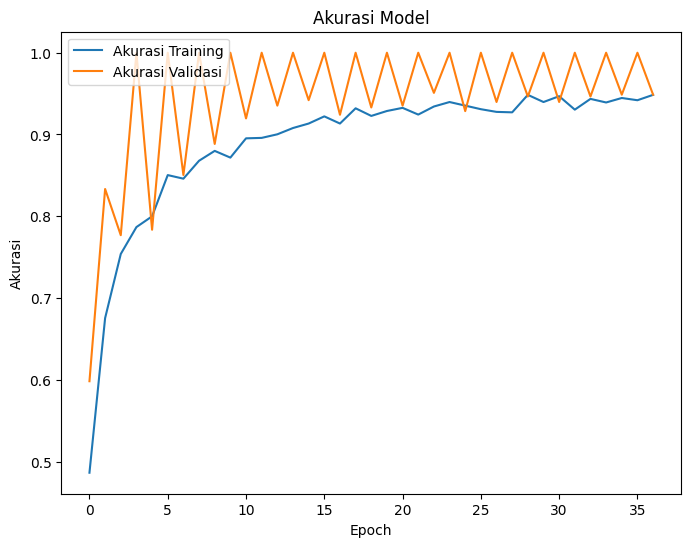

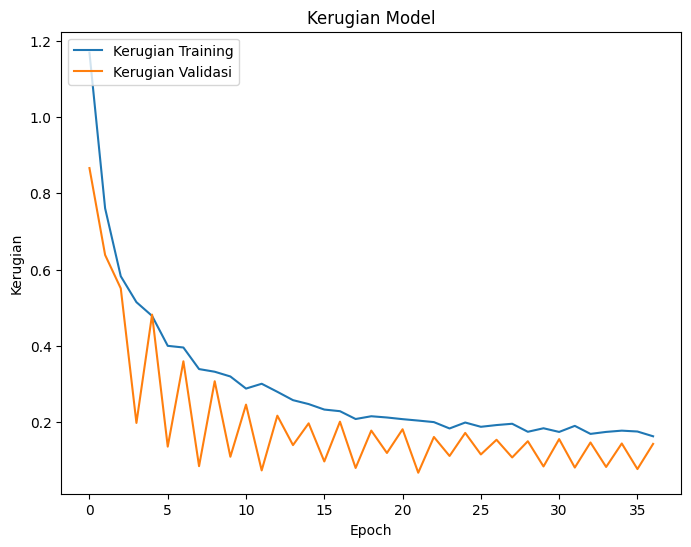

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Akurasi Training')
plt.plot(history.history['val_accuracy'], label='Akurasi Validasi')
plt.title('Akurasi Model')
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.legend(loc='upper left')
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Kerugian Training')
plt.plot(history.history['val_loss'], label='Kerugian Validasi')
plt.title('Kerugian Model')
plt.xlabel('Epoch')
plt.ylabel('Kerugian')
plt.legend(loc='upper left')
plt.show()

### Menyimpan dan Mengonversi Model

Model berhasil dimuat.
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 599ms/step - accuracy: 0.9514 - loss: 0.1960
Test Accuracy: 95.59%
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 856ms/step
Classification Report:
              precision    recall  f1-score   support

    Immature       1.00      0.90      0.95        40
      Mature       0.94      0.96      0.95        48
      Normal       0.94      1.00      0.97        48

    accuracy                           0.96       136
   macro avg       0.96      0.95      0.96       136
weighted avg       0.96      0.96      0.96       136



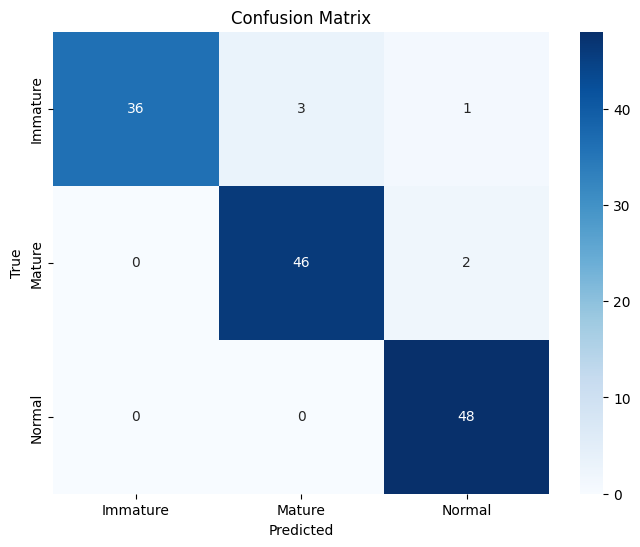

Model berhasil disimpan sebagai 'final_cataract_model.keras'
INFO:tensorflow:Assets written to: C:\Users\Ria\AppData\Local\Temp\tmpjytpp3ct\assets


INFO:tensorflow:Assets written to: C:\Users\Ria\AppData\Local\Temp\tmpjytpp3ct\assets


Saved artifact at 'C:\Users\Ria\AppData\Local\Temp\tmpjytpp3ct'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  1621562171152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1621562172112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1621562170960: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1621562172880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1621562170384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1621562172496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1621562171920: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1621562171344: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1621562170768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1621562173456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1621562

In [17]:
import os
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

if os.path.exists('best_cataract_model.keras'):
    model.load_weights('best_cataract_model.keras') 
    print("Model berhasil dimuat.")
else:
    print("File 'best_cataract_model.keras' tidak ditemukan. Pastikan model telah disimpan sebelumnya.")
    raise FileNotFoundError("Model file 'best_cataract_model.keras' tidak ditemukan.")

test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Membuat prediksi
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

# Laporan klasifikasi
print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_labels))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Simpan model dalam format Keras
try:
    model.save('final_cataract_model.keras')
    print("Model berhasil disimpan sebagai 'final_cataract_model.keras'")
except Exception as e:
    print(f"Gagal menyimpan model: {e}")

# Konversi ke TensorFlow Lite
try:
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    tflite_model = converter.convert()
    with open('cataract_model.tflite', 'wb') as f:
        f.write(tflite_model)
    print("Model berhasil dikonversi ke TensorFlow Lite.")
except Exception as e:
    print(f"Gagal mengonversi model ke TensorFlow Lite: {e}")